<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/Natural%20Language%20Processing/skip_gram_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##word2vec 
word2vec is not a singular algorithm, rather, it is a family of model architectures and optimizations that can be used to learn word embeddings from large datasets. 

Embeddings learned through word2vec have proven to be successful on a variety of downstream natural language processing tasks..

### Two methods for learning representations of words

* `Continuous bag-of-words model`: predicts the middle word based on surrounding context words.
  * a bag-of-words model predicts a word given the neighboring context

* `Continuous skip-gram model`: predicts words within a certain range before and after the current word in the same sentence.
  * a skip-gram model predicts the context (or neighbors) of a given word




## Skip-gram and negative sampling

Lets build a model that is trained on skip-grams, which are n-grams that allow tokens to be skipped. 

The context of a word can be represented through a set of skip-gram pairs of (target_word, context_word) where context_word appears in the neighboring context of target_word.


* The context words for a word in a sentence is defined by a window size. 

* The window size determines the span of words on either side of a target_word that can be considered a context word.

* A window size of `n` implies `n` words on each side of target-word , with a total window span of `2*n+1` words across a word.

**sample text** <br>
`The wide road shimmered in the hot sun.`

**target-word = `shimmered`**

**window size = 2** <br>
`The [wide road shimmered in the] hot sun.`

**skip-grams** <br>
* `shimmered wide`
* `shimmered road`
* `shimmered in`
* `shimmered the`


## Model architecture

<img src='https://miro.medium.com/max/720/1*fTjKtIwaRREoXh9Oj7zlyQ.webp'>

## Cost function

* The training objective of the skip-gram model is to maximize the probability of predicting context words given the target word. 

**cost function**

`log(p(context-word | target-word, theta))`

`theta` represent the model parameters that we have to learn

we seek model parameters that optimize this cost function

**The basic skip-gram formulation defines this probability using the softmax function.**

<img src='https://miro.medium.com/max/720/1*DV1xvqFEB12EI776KpEPhA.webp'>

## Bottle-neck

<img src='https://miro.medium.com/max/720/1*rBtSsuivvRdxUVOXD7Xc_w.webp'>

**Computing the denominator of this formulation involves performing a full softmax over the entire vocabulary words, which are often very large**

How can we overcome this bottleneck layer?

Can we approxiamte the softmax-layer? 

## Noise Contrastive Estimation (NCE) as loss function
The noise contrastive estimation (NCE) loss function is an efficient approximation for a full softmax. 

With an objective to learn word embeddings instead of modeling the word distribution, the NCE loss can be simplified to use negative sampling.

## What is negative sampling?

The simplified negative sampling objective for a target word is to distinguish the context word from `num_ns` negative samples drawn from noise distribution `Pn(w)` of words. 

## An efficient approximation of full softmax over the vocabulary
Pose the loss for a target word as a classification problem between the `context word` and `num_ns` negative samples.

## An example of a negative-sample
Words that does not appear in the context-window of the target word

**sample text** <br>
`The wide road shimmered in the hot sun.`

**target-word = `shimmered`**

**window size = 2** <br>
`The [wide road shimmered in the] hot sun.`

**negative-sample** <br>
* `<target-word negative-sample>`
* `shimmered The`
* `shimmered hot`
* `shimmered sun`


In [1]:
import pathlib
import string

import tensorflow as tf
import numpy as np

## Download text corpus 🧲

In [2]:
path_to_file = tf.keras.utils.get_file(fname='shakespeare.txt', origin='https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

path_to_file = pathlib.Path(path_to_file)

### Lets view sentences from the corpus 👓

In [3]:
raw = path_to_file.read_text(encoding='utf-8')
lines = raw.splitlines()

# print first 25 lines
print('\n'.join(lines[:25]))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!



### Create a dataset 📘
* Read the data
* Split the lines
* Filter off new-lines and whitespaces

In [4]:
lines_ds = tf.data.TextLineDataset(filenames=path_to_file).filter(lambda x: tf.strings.length(x)>0)

for line in lines_ds.take(5):
  print(line)

tf.Tensor(b'First Citizen:', shape=(), dtype=string)
tf.Tensor(b'Before we proceed any further, hear me speak.', shape=(), dtype=string)
tf.Tensor(b'All:', shape=(), dtype=string)
tf.Tensor(b'Speak, speak.', shape=(), dtype=string)
tf.Tensor(b'First Citizen:', shape=(), dtype=string)


## Vectorize sentences from the corpus 📖

* Convert the sentences to lowercase
* Remove punctuation

In [5]:
def custom_standardizer(input):
  lower = tf.strings.lower(input)
  remove_punctuation = tf.strings.regex_replace(input=lower, pattern=f'[{string.punctuation}]', rewrite='')
  return remove_punctuation

In [6]:
# Define the vocabulary size and the number of words in a sequence.
vocab_size = 4096
sequence_length = 10

In [7]:
vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, standardize=custom_standardizer,
                                               output_mode='int', output_sequence_length=sequence_length)

#### Call TextVectorization.adapt on the text dataset to create vocabulary.

In [8]:
vectorizer.adapt(lines_ds.batch(1024))

In [9]:
vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'to', 'i', 'of', 'you', 'my', 'a']

### Vectorized text

In [10]:
vectorized_ds = lines_ds.batch(1024).prefetch(tf.data.AUTOTUNE).map(vectorizer).unbatch()

In [11]:
vectorized_text = list(vectorized_ds.as_numpy_iterator())

for vector in vectorized_text[:5]:
  print(vector,'==>',[vectorizer.get_vocabulary()[i] for i in vector ])

[ 89 270   0   0   0   0   0   0   0   0] ==> ['first', 'citizen', '', '', '', '', '', '', '', '']
[138  36 982 144 673 125  16 106   0   0] ==> ['before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', '', '']
[34  0  0  0  0  0  0  0  0  0] ==> ['all', '', '', '', '', '', '', '', '', '']
[106 106   0   0   0   0   0   0   0   0] ==> ['speak', 'speak', '', '', '', '', '', '', '', '']
[ 89 270   0   0   0   0   0   0   0   0] ==> ['first', 'citizen', '', '', '', '', '', '', '', '']


## Generate skip-grams 

The `tf.keras.preprocessing.sequence` module provides useful functions that simplify data preparation for word2vec. 


* use the `tf.keras.preprocessing.sequence.skipgrams`

### Skip-gram sampling table
A large dataset means larger vocabulary with higher number of more frequent words such as stopwords. 

Training examples obtained from sampling commonly occurring words don't add much useful information for the model to learn from. 

It's recommended to subsampling of frequent words as a helpful practice to improve embedding quality.

The `tf.keras.preprocessing.sequence.skipgrams` function accepts a sampling table argument to encode probabilities of sampling any token. 

You can use the `tf.keras.preprocessing.sequence.make_sampling_table` to generate a word-frequency rank based probabilistic sampling table and pass it to the skipgrams function.


In [12]:
WINDOW = 2

In [13]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=vectorizer.vocabulary_size())

### Generate positive skip-grams from one sentence

Lets to set the `negative_samples` param to `zero` to generate only postive skip-grams


In [14]:
sentence = vectorized_text[1]
print(sentence,'==>',[vectorizer.get_vocabulary()[i] for i in sentence ])

[138  36 982 144 673 125  16 106   0   0] ==> ['before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', '', '']


In [15]:
positive_skip_grams, label = tf.keras.preprocessing.sequence.skipgrams(sequence=sentence, 
                                                          vocabulary_size=vectorizer.vocabulary_size(),
                                                          window_size=WINDOW, negative_samples=0.0, 
                                                          sampling_table=sampling_table)

Print a few positive skip-grams:

In [16]:
for target_word, context_word in positive_skip_grams:
  print(f'{vectorizer.get_vocabulary()[target_word]} [{target_word}] <===> {vectorizer.get_vocabulary()[context_word]} [{context_word}]' )

we [36] <===> before [138]
we [36] <===> proceed [982]
we [36] <===> any [144]


### Negative sampling for non-context words

The skipgrams function returns all positive skip-gram pairs by sliding over a given window span. 

**To produce additional skip-gram pairs that would serve as negative samples for training, you need to sample random words from the vocabulary.**


* Use the `tf.random.log_uniform_candidate_sampler` function to sample `num_ns` number of negative samples for a given target word in a window. 

* **Key Point**: `num_ns` in the `[5, 20]` range is shown to work best for smaller datasets, while num_ns in the `[2, 5]` range suffices for larger datasets.

In [17]:
# Get target and context words for one positive skip-gram.
target_word, context_word = positive_skip_grams[0]

# Set the number of negative samples per positive context.
num_ns = 4

In [18]:
print('TARGET WORD  :',target_word)
print('CONTEXT WORD :',context_word)

TARGET WORD  : 36
CONTEXT WORD : 138


`tf.random.log_uniform_candidate_sampler`

* `true_classes`	A Tensor of type int64 and shape `[batch_size,num_true]`. The target classes.
* `num_true`	An int. The number of target classes per training example.
* `num_sampled`	An int. The number of classes to randomly sample.
* `unique`	A bool. Determines whether all sampled classes in a batch are unique.
* `range_max`	An int. The number of possible classes.
* `seed`	An int. An operation-specific seed. Default is 0.
* `name`	A name for the operation (optional).

In [19]:
context_class = tf.constant(context_word, dtype=tf.int64)
context_class = tf.reshape(context_class, shape=[1,1])

context_class

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[138]])>

In [20]:
sampled_candidates,_,_=   tf.random.log_uniform_candidate_sampler(true_classes=context_class, num_true=1, 
                                                               num_sampled=num_ns,
                                                               unique=True, 
                                                               range_max=vectorizer.vocabulary_size())

In [21]:
sampled_candidates

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([  49, 1053,    8,    9])>

In [22]:
[vectorizer.get_vocabulary()[i] for i in sampled_candidates] 

['come', 'struck', 'my', 'a']

### Construct one training example

For a given positive (target_word, context_word) skip-gram, you now also have `num_ns` negative sampled context words that do not appear in the window size neighborhood of target_word. 

one training example = `(target_word, [context_word, negative_samples], [labels])`

In [23]:
context_and_negatives = [context_word, *sampled_candidates.numpy()]
labels = [1] + [0]*num_ns

In [24]:
training_example = (target_word, context_and_negatives, labels)
training_example

(36, [138, 49, 1053, 8, 9], [1, 0, 0, 0, 0])

### Skip-grams generator

In [25]:

def skip_grams_generator(inputs, vocab_size, num_ns, window_size, seed):
  target_words, context_and_negatives, labels = [],[],[]
  # SAMPLING TABLE
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=vocab_size)
  for sentence_vector in inputs:
    # POSITIVE SKIP GRAMS
    positive_skip_grams,_ = tf.keras.preprocessing.sequence.skipgrams(sequence=sentence_vector,
                                                                    vocabulary_size=vocab_size,
                                                                    window_size=window_size,
                                                                    negative_samples=0.0,
                                                                    sampling_table=sampling_table)
    # NEGATIVE SAMPLING
    for target_word, context_word in positive_skip_grams:
      context_class = tf.constant(context_word, dtype=tf.int64)
      context_class = tf.reshape(context_class, shape=[1,1])
      negative_samples,_,_=   tf.random.log_uniform_candidate_sampler(true_classes=context_class, num_true=1, 
                                                               num_sampled=num_ns,
                                                               unique=True, 
                                                               range_max=vocab_size,
                                                               seed=seed)

    
      # TARGET WORDS
      target_words.append(target_word)
      # CONTEXT AND NEGATIVES
      concated = tf.concat([tf.squeeze(context_class, axis=1) ,sampled_candidates], axis=0)
      context_and_negatives.append(concated)
      # LABELS
      label = tf.constant([1]+[0]*num_ns, dtype=tf.int64)
      labels.append(label)

  
  return np.array(target_words), np.array(context_and_negatives), np.array(labels)
    

In [26]:
target_words, context_and_negatives, labels = skip_grams_generator(vectorized_text,
                                                                   vocab_size=vectorizer.vocabulary_size(),
                                                                   num_ns=4,
                                                                   window_size=2,
                                                                   seed=42)

In [27]:
print('TARGET WORDS SHAPE : ',target_words.shape)
print('CONTEXT AND NEGATIVE SAMPLES SHAPE : ',context_and_negatives.shape)
print('LABELS SHAPE : ',labels.shape)

TARGET WORDS SHAPE :  (65411,)
CONTEXT AND NEGATIVE SAMPLES SHAPE :  (65411, 5)
LABELS SHAPE :  (65411, 5)


In [28]:
print('TARGET WORDS example : ',target_words[0])
print('CONTEXT AND NEGATIVE SAMPLES example : ',context_and_negatives[0])
print('LABELS example : ',labels[0])

TARGET WORDS example :  270
CONTEXT AND NEGATIVE SAMPLES example :  [  89   49 1053    8    9]
LABELS example :  [1 0 0 0 0]


### Create a training example

In [29]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
train_ds = tf.data.Dataset.from_tensor_slices(((target_words, context_and_negatives), labels))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

### Configure for performance
* Apply Dataset.cache and Dataset.prefetch to improve performance:

In [30]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)

In [31]:
# lets looks at a training sample
train_batch, label_batch = next(iter(train_ds))

example_target_batch, example_context_batch = train_batch
example_target = example_target_batch[0]
example_context = example_context_batch[0]
example_label = label_batch[0]

print('TARGET WORD example : ',example_target)
print('CONTEXT AND NEGATIVE SAMPLEs example : ',example_context)
print('LABELS example : ',example_label)

TARGET WORD example :  tf.Tensor(148, shape=(), dtype=int64)
CONTEXT AND NEGATIVE SAMPLEs example :  tf.Tensor([ 225   49 1053    8    9], shape=(5,), dtype=int64)
LABELS example :  tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


## Modeling 

The word2vec model can be implemented as a classifier to identify the true context words from skip-grams.

* a training example = `(target_word, [context_word, negative_samples], [labels])`

The false context words are obtained through negative sampling. 

We can perform a dot product multiplication between the embeddings of target and context words to obtain predictions for labels and compute the loss function against true labels in the dataset.


####  Use the Keras Subclassing API to define your word2vec model with the following layers:

* `target_embedding`: A `tf.keras.layers.Embedding layer`, which looks up the embedding of a word 

* `context_embedding`: Another `tf.keras.layers.Embedding layer`, which looks up the embedding of a word

* Create a layer that computes the dot product of target and context embeddings from a training pair.

* `flatten`: A `tf.keras.layers.Flatten` layer to flatten the results of dots layer into logits.

With the subclassed model, you can define the call() function that accepts `(target, context)` pairs which can then be passed into their corresponding embedding layer. 

Reshape the context_embedding to perform a dot product with target_embedding and return the flattened result.



In [32]:
class SkipGramModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(SkipGramModel, self).__init__()
    self.target_embed = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='target_embedding')
    self.context_embed = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='context_embedding')

  # FORWARD PASS
  def call(self, inputs):
    target, context = inputs

    # [batch, ] --> [batch, embed_dims]
    target_embedding = self.target_embed(target)
    # [batch, seq] --> [batch, seq, embed_dims]
    context_embedding = self.context_embed(context)

    # use dot-product to find similarity score
    dots = tf.einsum('be,bse->bs', target_embedding, context_embedding)

    return dots



In [33]:
EMBED_DIMS = 128
model = SkipGramModel(vocab_size=vectorizer.vocabulary_size(), embedding_dim=EMBED_DIMS)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [34]:
history = model.fit(train_ds, epochs=10)

Epoch 1/10
63/63 [==============================] - 2s 21ms/step - loss: 1.5526 - accuracy: 0.7089
Epoch 2/10
63/63 [==============================] - 1s 18ms/step - loss: 0.9584 - accuracy: 0.9754
Epoch 3/10
63/63 [==============================] - 1s 16ms/step - loss: 0.3201 - accuracy: 0.9821
Epoch 4/10
63/63 [==============================] - 1s 17ms/step - loss: 0.1487 - accuracy: 0.9841
Epoch 5/10
63/63 [==============================] - 1s 17ms/step - loss: 0.1039 - accuracy: 0.9849
Epoch 6/10
63/63 [==============================] - 1s 17ms/step - loss: 0.0858 - accuracy: 0.9857
Epoch 7/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0762 - accuracy: 0.9865
Epoch 8/10
63/63 [==============================] - 1s 17ms/step - loss: 0.0703 - accuracy: 0.9875
Epoch 9/10
63/63 [==============================] - 1s 17ms/step - loss: 0.0662 - accuracy: 0.9886
Epoch 10/10
63/63 [==============================] - 1s 17ms/step - loss: 0.0633 - accuracy: 0.9898


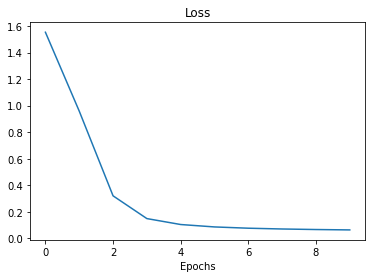

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss']);
plt.title('Loss')
plt.xlabel('Epochs');